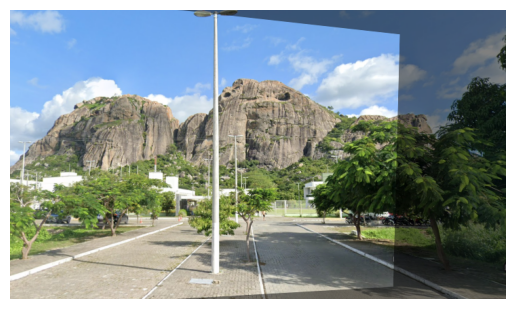

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

# Carregar imagens
image1 = cv2.imread("/content/campus_quixada1.png")
image2 = cv2.imread("/content/campus_quixada2.png")

# Verificar se as imagens foram carregadas corretamente
if image1 is None or image2 is None:
    raise AssertionError("Erro ao carregar imagens")

# Reduzir tamanho das imagens para melhor visualização
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]
image1 = cv2.resize(image1, (int(w1*0.5), int(h1*0.5)))
image2 = cv2.resize(image2, (int(w2*0.5), int(h2*0.5)))

# Converter para escala de cinza
img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Encontrar keypoints e descriptors com SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Verificar se há keypoints suficientes
if len(kp1) < 4 or len(kp2) < 4:
    raise AssertionError("Não há keypoints suficientes")

# Matching de keypoints com BFMatcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Aplicar ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

# Verificar se há matches suficientes
if len(good) < 4:
    raise AssertionError("Não há matches suficientes")

# Extrair localizações dos bons matches
pts1 = []
pts2 = []
for m in good:
    pts1.append(kp1[m[0].queryIdx].pt)
    pts2.append(kp2[m[0].trainIdx].pt)

# Matrix points
points1 = np.float32(pts1).reshape(-1, 1, 2)
points2 = np.float32(pts2).reshape(-1, 1, 2)

# Encontrar homografia usando RANSAC
transformation_matrix, inliers = cv2.findHomography(points1, points2, cv2.RANSAC)

# Verificar se a transformação de homografia é precisa
if transformation_matrix is None:
    raise AssertionError("Erro ao calcular a transformação de homografia")

# Combinar imagens
height, width = img2.shape
img1_transformed = cv2.warpPerspective(image1, transformation_matrix, (width, height))

# Criar uma imagem para mostrar a combinação
combined_img = cv2.addWeighted(img1_transformed, 0.5, image2, 0.5, 0)

# Mostrar a imagem combinada usando matplotlib
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()